# Algorithms in Structural Biology
## Homework 1
### Question 2: cRMSD - dRMSD
#### Andrinopoulou Christina (ds2200013)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import random
import math

Steps of algorithm:
- Find the centroid of each conformation 
- Move the conformations to the origin of the space: Subtract the centroids from each coordinate
- Singular Value Decomposition (SVD): best transformation Q for the conformation 
- Apply transformation to a conformation 
- Calculate the corresponding cRMSD distance

In [2]:
class cRMSD:
    def __init__(self, filename='80_conformations.txt'):
        self.filename = filename
        self.conformations, self.number_of_conformations, self.number_of_atoms = self.read_conformations()
        self.centroid_1 = []
        self.centroid_2 = []
        self.U = np.empty((3,3))
        self.Sigma = np.empty((0,3))
        self.VT = np.empty((3,3))
        self.Q = np.empty((3,3))
        
    
    # read the conformations from the txt file
    def read_conformations(self):
        f = open(self.filename)
        lines = f.readlines()
        conformations = int(lines[0])
        atoms = int(lines[1])
        
        df = pd.read_csv('80_conformations.txt', delimiter = "\t", skiprows=2, header=None)
        list_of_conformation = np.array_split(df, 80)
        conformations_dict = { i : list_of_conformation[i] for i in range(len(list_of_conformation))}

        f.close()
        return conformations_dict, conformations, atoms
        
        
    # calculate the centroid
    def find_centroid(self, conformation1, conformation2):
        sum_result1 = conformation1.sum(axis = 0)
        sum_result2 = conformation2.sum(axis = 0)
        self.centroid_1 = [sum_result1[i]/self.number_of_atoms for i in range(len(sum_result1))]
        self.centroid_2 = [sum_result2[i]/self.number_of_atoms for i in range(len(sum_result2))]
        
        
    # move the conformations to the origin
    def move_to_origin(self, conformation1, conformation2):
        number_of_cols = conformation1.shape[1]
        for i in range(number_of_cols):
            conformation1[i] -= self.centroid_1[i]
            conformation2[i] -= self.centroid_2[i]
        return conformation1, conformation2
        
       
    # find best tranformation of one conformation, using SVD
    def SVD_process(self, conformation1, conformation2):
        XT_Y = np.matmul(conformation1.T.to_numpy(), conformation2.to_numpy())
        self.U, self.Sigma, self.VT = np.linalg.svd(XT_Y)
        self.Q = np.matmul(self.U, self.VT)
        detQ = np.linalg.det(self.Q)
        if detQ < 0:
            self.U[2] = -self.U[2]
            self.Q = np.matmul(self.U, self.VT)        
        
    
    # calculate cRMSD
    def cRMSD_distance(self, conformation1, conformation2):
        temp = np.matmul(conformation1.to_numpy(), self.Q) - conformation2.to_numpy()
    
        sum_norms = 0
        for i in range(temp.shape[0]):
            sum_norms += pow(np.linalg.norm(temp[i]),2)
        return math.sqrt(sum_norms/self.number_of_atoms)
     
       
    # compare two conformations
    def compare(self, conformation1, conformation2, print_flag=False):
        self.find_centroid(conformation1, conformation2)
        conformation1, conformation2 = self.move_to_origin(conformation1, conformation2)
        self.SVD_process(conformation1, conformation2)
        c_rmsd = self.cRMSD_distance(conformation1, conformation2)
        if print_flag:
            print(f'cRMSD = {c_rmsd}')
        return c_rmsd
        
       
    # comare all possible pairs of confomations 
    def compare_all(self):
        distances = []
        for i in range(self.number_of_conformations):
            for j in range(self.number_of_conformations):
                if i < j:
                    distances.append(self.compare(self.conformations[i], self.conformations[j]))
        mean = statistics.mean(distances)
        median = statistics.median(distances)
        print(f'Mean: {mean}')
        print(f'Median: {median}')
        plt.hist(distances, bins=10)
        plt.title('cRMSD')
        plt.xlabel('Distance')
        plt.ylabel('Frequency')
        plt.show()
        
        
    # get the important parameters of the class   
    def get_params(self):
        return {'Conformations': self.conformations,
                'Number_of_Conformations': self.number_of_conformations,
                'Number_of_atoms': self.number_of_atoms,
                'Centroid_1': self.centroid_1,
                'Centroid_2': self.centroid_2,
                'U': pd.DataFrame(self.U),
                'Sigma': pd.DataFrame(self.Sigma),
                'V': pd.DataFrame(self.VT.transpose()),
                'Q': pd.DataFrame(self.Q),
        }

#### Compute the optimal translation and rotation minimizing c-RMSD between the first 2 conformations

In [3]:
c_rmsd = cRMSD()
params = c_rmsd.get_params()
c_rmsd.compare(conformation1=params['Conformations'][0], conformation2=params['Conformations'][1], print_flag=True)
params = c_rmsd.get_params()
header = '#'*51 
print(header+' U '+header)
print(params['U'].to_string())
header = '#'*51 
print(header+' Sigma '+header)
print(params['Sigma'].to_string())
header = '#'*51 
print(header+' V '+header)
print(params['V'].to_string())
header = '#'*51 
print(header+' Q '+header)
print(params['Q'].to_string())

cRMSD = 0.6271694758794248
################################################### U ###################################################
          0         1         2
0 -0.614345  0.311999 -0.724732
1 -0.046984 -0.931337 -0.361115
2 -0.787637 -0.187799  0.586821
################################################### Sigma ###################################################
              0
0  34676.241277
1   8650.358619
2   5259.297438
################################################### V ###################################################
          0         1         2
0 -0.613880  0.311817 -0.725204
1 -0.050610 -0.932335 -0.358035
2 -0.787775 -0.183088  0.588123
################################################### Q ###################################################
          0         1         2
0  1.000000 -0.000315  0.000611
1  0.000318  0.999988 -0.004851
2 -0.000609  0.004851  0.999988


#### Compute the c-RMSD distances between all ${80 \choose 2}$ pairs of conformations

Mean: 11.015199832626305
Median: 10.853087486496054


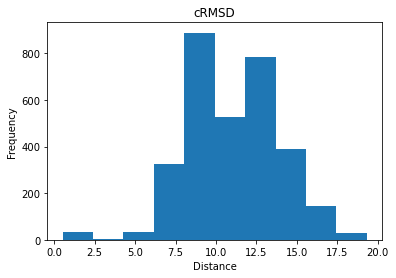

In [4]:
c_rmsd.compare_all()

The dRMSD distnace is based on the distances between the atoms of each conformation and is calculated based on the formula below:

\begin{align*}
    dRMSD = \sqrt{\frac{1}{k} \sum_{i=1}^{k} (d_i - d_i')^2}
\end{align*}

In [5]:
class dRMSD:
    def __init__(self, filename='80_conformations.txt'):
        self.filename = filename
        self.conformations, self.number_of_conformations, self.number_of_atoms = self.read_conformations()
        
        
    def read_conformations(self):
        f = open(self.filename)
        lines = f.readlines()
        conformations = int(lines[0])
        atoms = int(lines[1])
        
        df = pd.read_csv('80_conformations.txt', delimiter = "\t", skiprows=2, header=None)
        list_of_conformation = np.array_split(df, 80)
        conformations_dict = { i : list_of_conformation[i] for i in range(len(list_of_conformation))}

        f.close()
        return conformations_dict, conformations, atoms
    
    
    def compare(self, x, y, random_flag=False):
        sum_value = 0
        k = 0
        
        conformation_1 = self.conformations[x].to_numpy()
        conformation_2 = self.conformations[y].to_numpy()
        
        if random_flag:
            random_indexes = [(random.randint(0, self.number_of_atoms-1), random.randint(0, self.number_of_atoms-1)) for i in range(3*self.number_of_atoms)]
            for k in range(self.number_of_atoms):
                i = random_indexes[k][0]
                j = random_indexes[k][1]
                atom_x_1 = conformation_1[i]
                atom_y_1 = conformation_2[i]
                atom_x_2 = conformation_1[j]
                atom_y_2 = conformation_2[j]
                dist_x = np.linalg.norm(atom_x_1 - atom_x_2)
                dist_y = np.linalg.norm(atom_y_1 - atom_y_2)
                sum_value += pow(dist_x-dist_y, 2)
            return math.sqrt(sum_value/k)

        for i in range(self.number_of_atoms):
            atom_x_1 = conformation_1[i]
            atom_y_1 = conformation_2[i]
            for j in range(self.number_of_atoms):
                if i < j:
                    k += 1
                    atom_x_2 = conformation_1[j]
                    atom_y_2 = conformation_2[j]
                    dist_x = np.linalg.norm(atom_x_1 - atom_x_2)
                    dist_y = np.linalg.norm(atom_y_1 - atom_y_2)
                    sum_value += pow(dist_x-dist_y, 2)
                    
        return math.sqrt(sum_value/k)
    
    
    def compare_all(self, random_flag=False):
        distances = []
        for i in range(self.number_of_conformations):
            for j in range(self.number_of_conformations):
                if i < j:
                    distances.append(self.compare(i, j, random_flag))
        mean = statistics.mean(distances)
        median = statistics.median(distances)
        print(f'Mean: {mean}')
        print(f'Median: {median}')
        plt.hist(distances, bins=10)
        plt.title('dRMSD')
        plt.xlabel('Distance')
        plt.ylabel('Frequency')
        plt.show()
                    


#### Compute the d-RMSD distances between all ${369 \choose 2}$ pairs of distances within each conformation
**ATTENTION: The execution time of this function is high. It is not recommended to re-execute it if there is not enough time.**

Mean: 6.7950321975044385
Median: 6.468606946347217


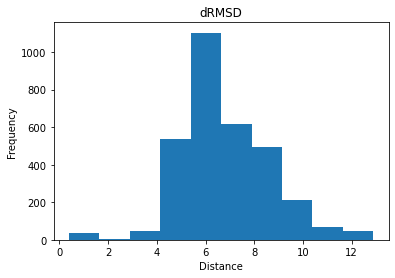

In [6]:
d_rmsd = dRMSD()
d_rmsd.compare_all()

#### Compute the d-RMSD distances between a random subset of k = 3n distances, where n=369

Mean: 6.789508038926164
Median: 6.456979538046951


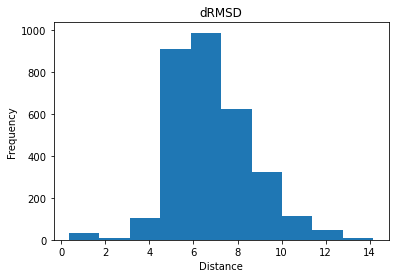

In [6]:
d_rmsd = dRMSD()
d_rmsd.compare_all(random_flag=True)